# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [17]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    loss_function = nn.NLLLoss()
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        # for each batch
        if use_cuda:
            # transfer to GPU
            data = data.cuda()
            target = target.cuda()
    
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        out = model(data)      
        
        # TODO: compute negative log likelihood loss
        loss = loss_function(out, target)

        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()       
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print("Loss: " + str(loss.item()))



We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1,784)      
        
        # TODO: run network layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(self.fc5(x), dim=1)
        #output = F.softmax(self.fc5(x), dim=1)
        
        return output

In [25]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)

    def forward(self, x):
        x = x.view(-1,784)      
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        output = F.log_softmax(self.fc5(x), dim=1)
        
        return output

In [26]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        self.fc1 = nn.Linear(784,200)
        self.fc1_bn = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc3_bn = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)

    def forward(self, x):
        x = x.view(-1,784)      
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.relu(self.fc4(x))

        output = F.log_softmax(self.fc5(x), dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [36]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128,10)
              

    def forward(self, x):
        # TODO: run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1(x))
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(self.fc2(x), dim=1)
        
        return output

In [37]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(self.fc2(x), dim=1)
        
        return output

In [39]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(self.fc2(x), dim=1)
        
        return output

CUDA: True
Loss: 2.3629744052886963
Loss: 2.299060344696045

Test set: Average loss: 2.3078, Accuracy: 1010/10000 (10.10%)



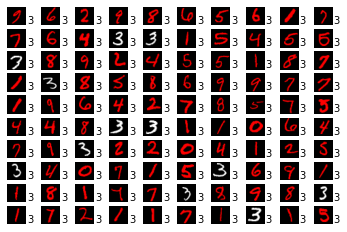

Loss: 2.3097846508026123
Loss: 2.0859456062316895

Test set: Average loss: 1.9328, Accuracy: 1875/10000 (18.75%)



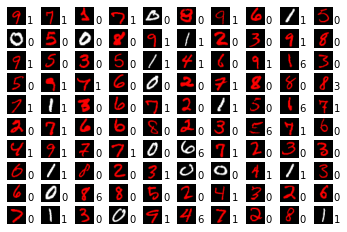

Loss: 1.9339959621429443
Loss: 1.3508766889572144

Test set: Average loss: 1.2389, Accuracy: 5659/10000 (56.59%)



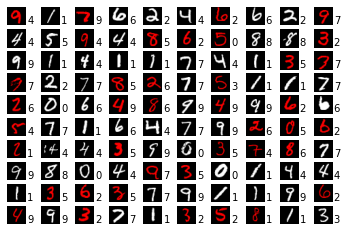

Loss: 1.2337546348571777
Loss: 0.8779770731925964

Test set: Average loss: 0.9270, Accuracy: 6933/10000 (69.33%)



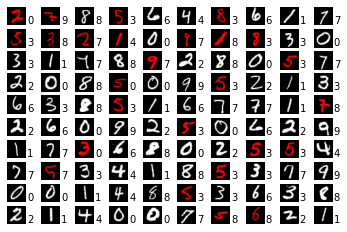

Loss: 0.8842517733573914
Loss: 0.7313786149024963

Test set: Average loss: 0.6260, Accuracy: 8177/10000 (81.77%)



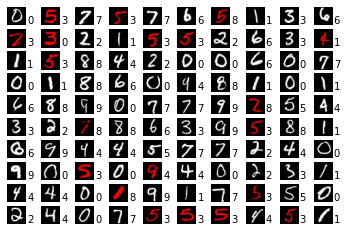

Loss: 0.5912164449691772
Loss: 0.5404239892959595

Test set: Average loss: 0.5223, Accuracy: 8657/10000 (86.57%)



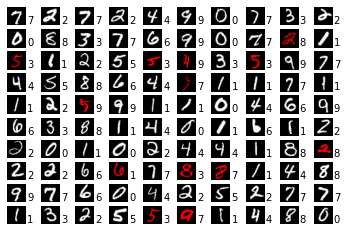

Loss: 0.4710027277469635
Loss: 0.5123154520988464

Test set: Average loss: 0.4682, Accuracy: 8911/10000 (89.11%)



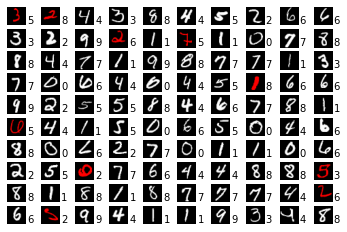

Loss: 0.380803644657135
Loss: 0.3704037666320801

Test set: Average loss: 0.4337, Accuracy: 9029/10000 (90.29%)



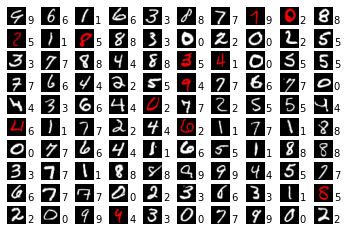

Loss: 0.39526286721229553
Loss: 0.4079439342021942

Test set: Average loss: 0.4090, Accuracy: 9036/10000 (90.36%)



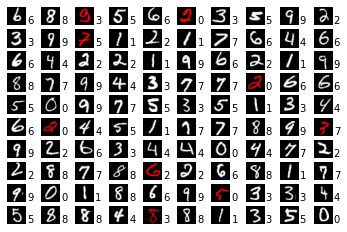

Loss: 0.4263850450515747
Loss: 0.38284242153167725

Test set: Average loss: 0.3928, Accuracy: 9125/10000 (91.25%)



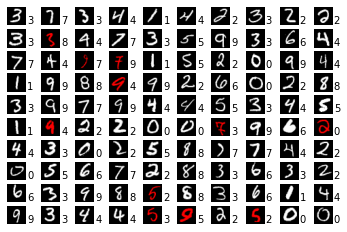

In [21]:
# hyper parameters
batch_size = 512 # 64
test_batch_size = 1000
epochs = 10
lr = 4.0 # 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
print("CUDA: " + str(use_cuda))
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

CUDA: True
Loss: 2.305490016937256
Loss: 0.39371752738952637

Test set: Average loss: 0.2597, Accuracy: 9229/10000 (92.29%)



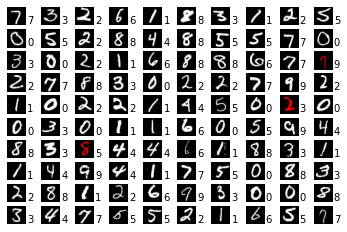

Loss: 0.22032205760478973
Loss: 0.12096498906612396

Test set: Average loss: 0.1782, Accuracy: 9503/10000 (95.03%)



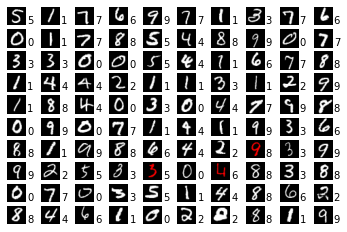

Loss: 0.17327894270420074
Loss: 0.07902315258979797

Test set: Average loss: 0.1114, Accuracy: 9661/10000 (96.61%)



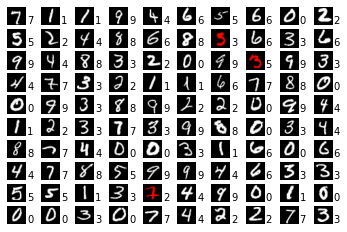

Loss: 0.07937350869178772
Loss: 0.07479176670312881

Test set: Average loss: 0.1174, Accuracy: 9662/10000 (96.62%)



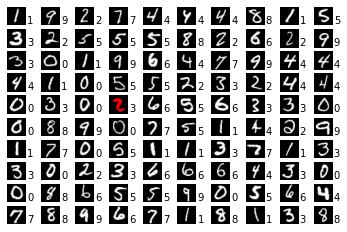

Loss: 0.10881780833005905
Loss: 0.05211170017719269

Test set: Average loss: 0.0853, Accuracy: 9748/10000 (97.48%)



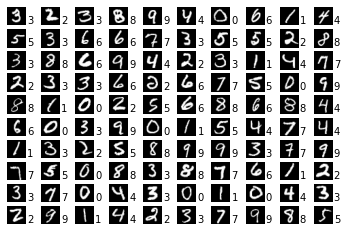

Loss: 0.0422348715364933
Loss: 0.03916554898023605

Test set: Average loss: 0.0835, Accuracy: 9767/10000 (97.67%)



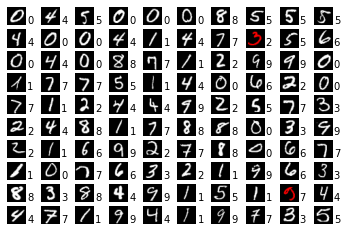

Loss: 0.026936545968055725
Loss: 0.010053573176264763

Test set: Average loss: 0.0837, Accuracy: 9777/10000 (97.77%)



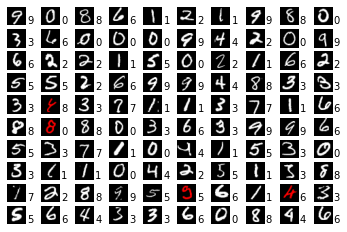

Loss: 0.011957140639424324
Loss: 0.04609852284193039

Test set: Average loss: 0.0829, Accuracy: 9776/10000 (97.76%)



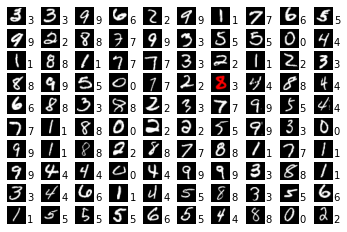

Loss: 0.025610189884901047
Loss: 0.0181061290204525

Test set: Average loss: 0.0829, Accuracy: 9784/10000 (97.84%)



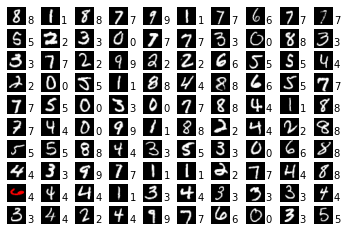

Loss: 0.0038702653255313635
Loss: 0.010818392969667912

Test set: Average loss: 0.0847, Accuracy: 9783/10000 (97.83%)



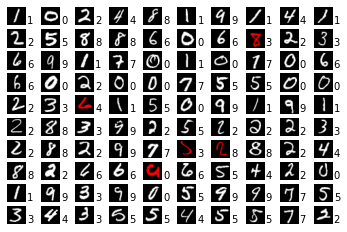

In [24]:
# hyper parameters
batch_size = 512 # 64
test_batch_size = 1000
epochs = 10
lr = 4.0 # 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
print("CUDA: " + str(use_cuda))
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

CUDA: True
Loss: 2.310048818588257
Loss: 0.1552717387676239

Test set: Average loss: 0.1908, Accuracy: 9416/10000 (94.16%)



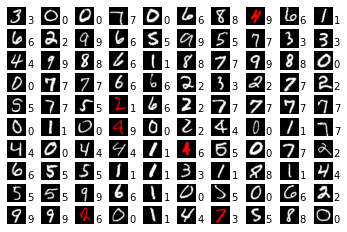

Loss: 0.22896860539913177
Loss: 0.04673054441809654

Test set: Average loss: 0.1572, Accuracy: 9546/10000 (95.46%)



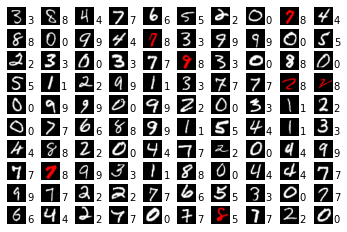

Loss: 0.13889957964420319
Loss: 0.052818093448877335

Test set: Average loss: 0.0980, Accuracy: 9708/10000 (97.08%)



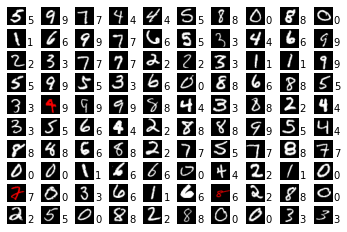

Loss: 0.07051856070756912
Loss: 0.029421698302030563

Test set: Average loss: 0.0595, Accuracy: 9824/10000 (98.24%)



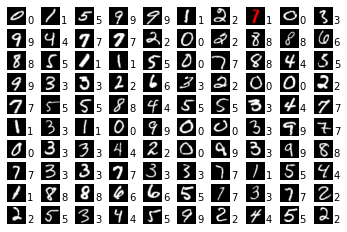

Loss: 0.020819587633013725
Loss: 0.016477331519126892

Test set: Average loss: 0.0569, Accuracy: 9840/10000 (98.40%)



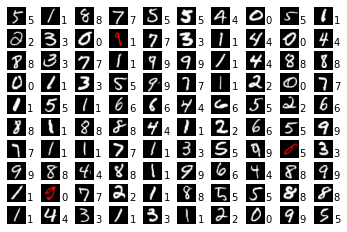

Loss: 0.008860049769282341
Loss: 0.019855299964547157

Test set: Average loss: 0.0570, Accuracy: 9840/10000 (98.40%)



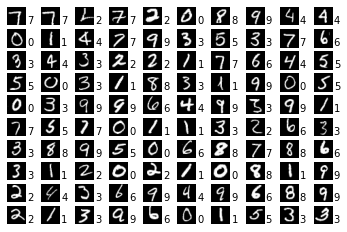

Loss: 0.005735657177865505
Loss: 0.018271135166287422

Test set: Average loss: 0.0546, Accuracy: 9853/10000 (98.53%)



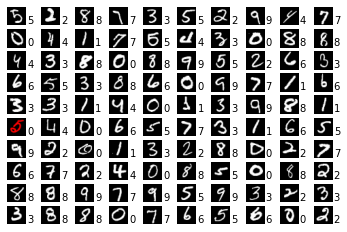

Loss: 0.003555670380592346
Loss: 0.0035884587559849024

Test set: Average loss: 0.0556, Accuracy: 9858/10000 (98.58%)



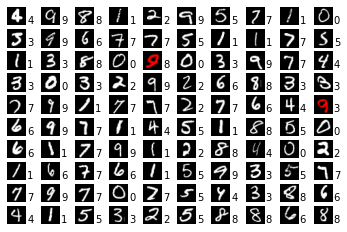

Loss: 0.00772840715944767
Loss: 0.0026840234640985727

Test set: Average loss: 0.0556, Accuracy: 9852/10000 (98.52%)



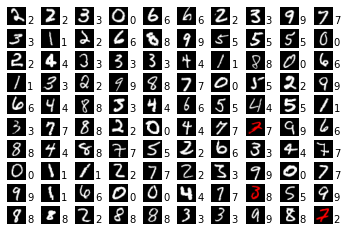

Loss: 0.0010564080439507961
Loss: 0.0026373763103038073

Test set: Average loss: 0.0560, Accuracy: 9846/10000 (98.46%)



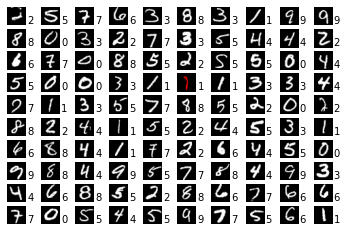

In [27]:
# hyper parameters
batch_size = 512 # 64
test_batch_size = 1000
epochs = 10
lr = 4.0 # 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
print("CUDA: " + str(use_cuda))
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

CUDA: True
Loss: 2.3046624660491943
Loss: 0.12592434883117676

Test set: Average loss: 0.0886, Accuracy: 9701/10000 (97.01%)



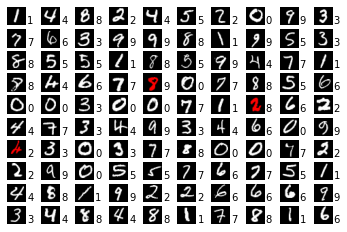

Loss: 0.05983005091547966
Loss: 0.048790425062179565

Test set: Average loss: 0.0512, Accuracy: 9834/10000 (98.34%)



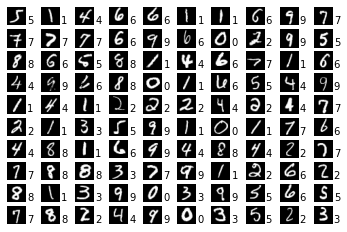

Loss: 0.025464732199907303
Loss: 0.02296769618988037

Test set: Average loss: 0.0391, Accuracy: 9875/10000 (98.75%)



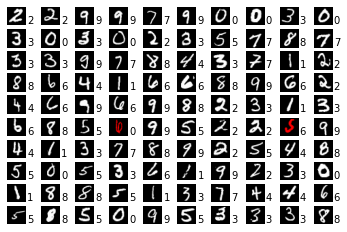

Loss: 0.015352010726928711
Loss: 0.007315535563975573

Test set: Average loss: 0.0485, Accuracy: 9850/10000 (98.50%)



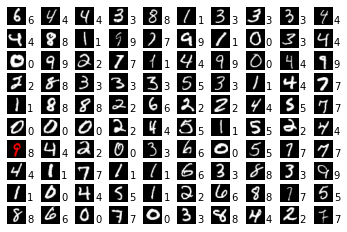

Loss: 0.014763956889510155
Loss: 0.007060231640934944

Test set: Average loss: 0.0327, Accuracy: 9899/10000 (98.99%)



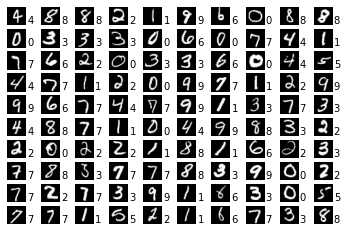

Loss: 0.015480869449675083
Loss: 0.01696229726076126

Test set: Average loss: 0.0330, Accuracy: 9895/10000 (98.95%)



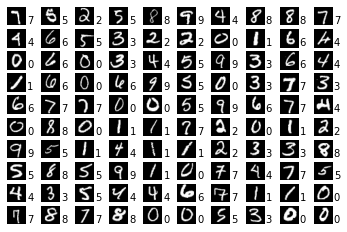

Loss: 0.0031893402338027954
Loss: 0.0019745551981031895

Test set: Average loss: 0.0356, Accuracy: 9896/10000 (98.96%)



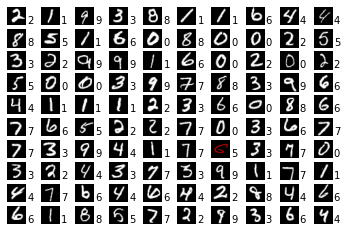

Loss: 0.0021686991676688194
Loss: 0.0013344070175662637

Test set: Average loss: 0.0350, Accuracy: 9895/10000 (98.95%)



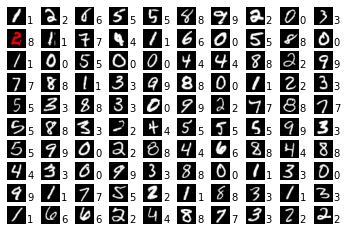

Loss: 0.005969477817416191
Loss: 0.005576226860284805

Test set: Average loss: 0.0357, Accuracy: 9896/10000 (98.96%)



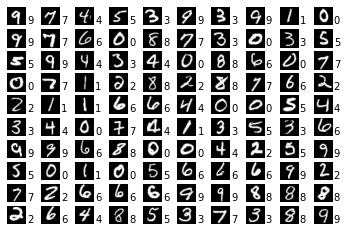

Loss: 0.002936052391305566
Loss: 0.011379879899322987

Test set: Average loss: 0.0363, Accuracy: 9899/10000 (98.99%)



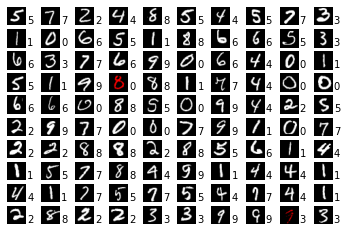

In [31]:
# hyper parameters
batch_size = 512 # 64
test_batch_size = 1000
epochs = 10
lr = 4.0 # 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
print("CUDA: " + str(use_cuda))
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

CUDA: True
Loss: 2.3864994049072266
Loss: 0.06547251343727112

Test set: Average loss: 0.1579, Accuracy: 9497/10000 (94.97%)



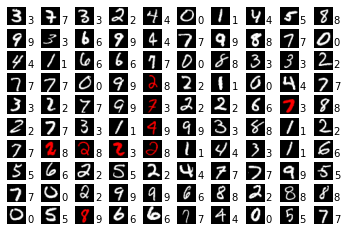

Loss: 0.0821700394153595
Loss: 0.025124622508883476

Test set: Average loss: 0.0429, Accuracy: 9867/10000 (98.67%)



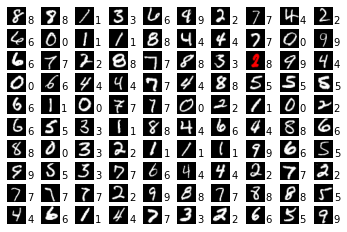

Loss: 0.018691690638661385
Loss: 0.01689109206199646

Test set: Average loss: 0.0351, Accuracy: 9878/10000 (98.78%)



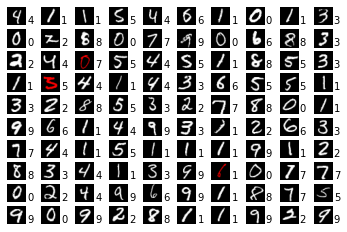

Loss: 0.019465576857328415
Loss: 0.0051880646497011185

Test set: Average loss: 0.0275, Accuracy: 9911/10000 (99.11%)



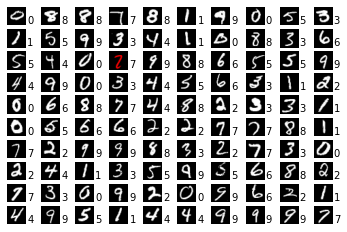

Loss: 0.0026417430490255356
Loss: 0.003121036570519209

Test set: Average loss: 0.0280, Accuracy: 9903/10000 (99.03%)



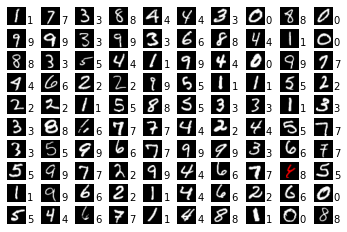

Loss: 0.0034148949198424816
Loss: 0.0012429957278072834

Test set: Average loss: 0.0292, Accuracy: 9903/10000 (99.03%)



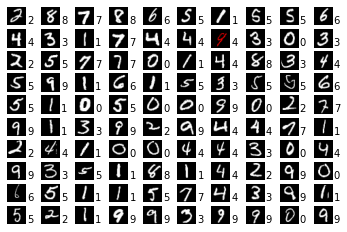

Loss: 0.0037134012673050165
Loss: 0.0020752418786287308

Test set: Average loss: 0.0287, Accuracy: 9902/10000 (99.02%)



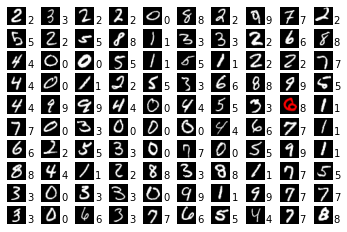

Loss: 0.0012756302021443844
Loss: 0.001701238565146923

Test set: Average loss: 0.0284, Accuracy: 9904/10000 (99.04%)



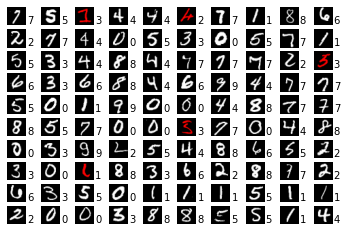

Loss: 0.0016059268964454532
Loss: 0.0017733381828293204

Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99.04%)



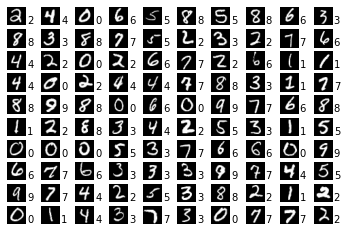

Loss: 0.0016740248538553715
Loss: 0.0016996758058667183

Test set: Average loss: 0.0288, Accuracy: 9900/10000 (99.00%)



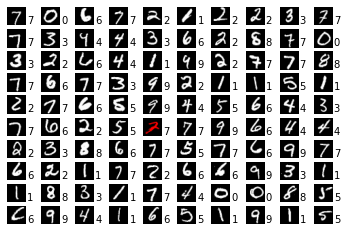

In [35]:
# hyper parameters
batch_size = 512 # 64
test_batch_size = 1000
epochs = 10
lr = 4.0 # 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
print("CUDA: " + str(use_cuda))
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    

CUDA: True
Loss: 2.3826615810394287
Loss: 0.0539502315223217

Test set: Average loss: 0.0545, Accuracy: 9828/10000 (98.28%)



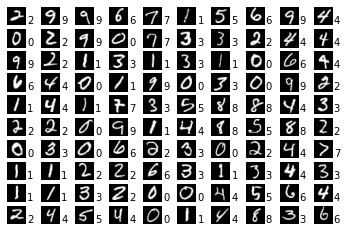

Loss: 0.028653627261519432
Loss: 0.021814722567796707

Test set: Average loss: 0.0684, Accuracy: 9785/10000 (97.85%)



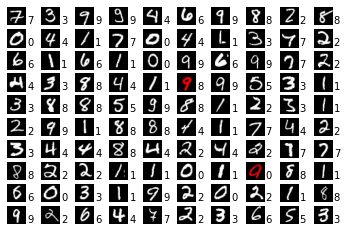

Loss: 0.03306195139884949
Loss: 0.012057928368449211

Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99.03%)



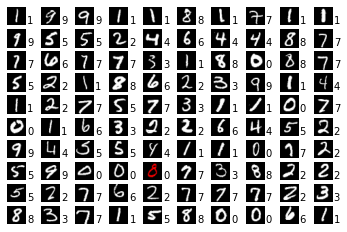

Loss: 0.007851325906813145
Loss: 0.007664936129003763

Test set: Average loss: 0.0346, Accuracy: 9881/10000 (98.81%)



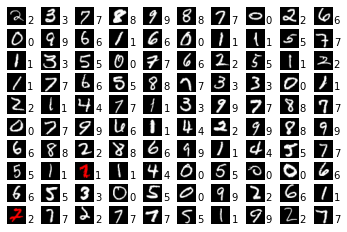

Loss: 0.0037332256324589252
Loss: 0.0029158140532672405

Test set: Average loss: 0.0275, Accuracy: 9916/10000 (99.16%)



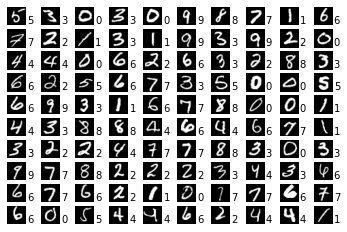

Loss: 0.0026127712335437536
Loss: 0.0013528087874874473

Test set: Average loss: 0.0257, Accuracy: 9916/10000 (99.16%)



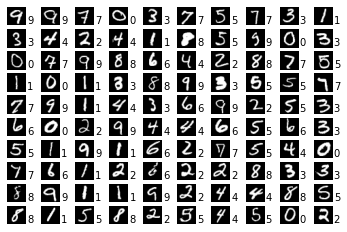

Loss: 0.0031213031616061926
Loss: 0.0030069465283304453

Test set: Average loss: 0.0257, Accuracy: 9914/10000 (99.14%)



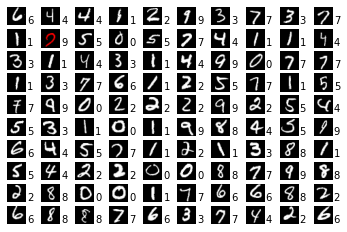

Loss: 0.0013858338352292776
Loss: 0.0017896512290462852

Test set: Average loss: 0.0257, Accuracy: 9917/10000 (99.17%)



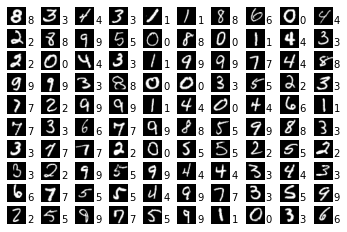

Loss: 0.0010301750153303146
Loss: 0.004865830764174461

Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99.15%)



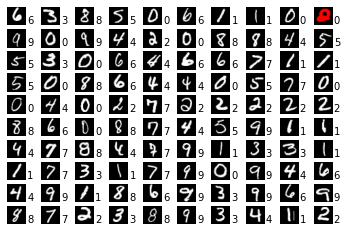

Loss: 0.0015001469291746616
Loss: 0.002235040534287691

Test set: Average loss: 0.0262, Accuracy: 9912/10000 (99.12%)



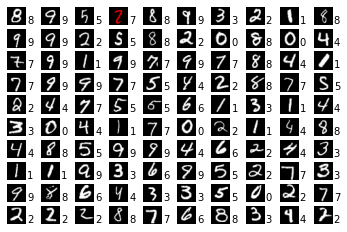

In [40]:
# hyper parameters
batch_size = 512 # 64
test_batch_size = 1000
epochs = 10
lr = 4.0 # 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
print("CUDA: " + str(use_cuda))
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    